In [8]:
import vtk
import math
import matplotlib.pyplot as plt
import numpy as np

ColorBackground = [0.0, 0., 0.]
Path = 'mesh_i1_n0.4.obj'

In [34]:
# accumulate contour, unfinished
class colon(object):
    def __init__(self, path):
        reader = vtk.vtkOBJReader()
        reader.SetFileName(Path)
        reader.Update()
        self.obj = reader.GetOutput()               
        self.math = vtk.vtkMath()
        
        # renderer
        self.ren = vtk.vtkRenderer()
        self.ren.SetBackground(ColorBackground)
        self.actors = {}
        
        # add colon
        # self.add_render(self.obj, 'main')
        
    
    def add_render(self, obj, name, color=None):
        # mapper, vtkPolyData to graphics primitives
        mapper = vtk.vtkPolyDataMapper()
        mapper.SetInputData(obj)
        # actor, represents an object (geometry & properties) in a rendered scene
        actor = vtk.vtkActor()
        actor.SetMapper(mapper)
        if color:
            actor.GetProperty().SetColor(color)
        
        self.actors[name] = actor
        self.ren.AddActor(self.actors[name])
    
    def remove_render(self, name):
        self.ren.RemoveActor(self.actors[name])
        del self.actors[name]
    
    def visual(self):        
        # render window
        renWin = vtk.vtkRenderWindow()
        renWin.AddRenderer(self.ren)
        # Create a renderwindowinteractor
        iren = vtk.vtkRenderWindowInteractor()
        iren.SetRenderWindow(renWin)
        # visualize
        iren.Initialize()
        renWin.Render()
        iren.Start()
        
    def set_centerline(self, resolution):
        xmin,xmax, ymin,ymax, zmin,zmax = self.obj.GetBounds()
        center = self.obj.GetCenter() # colon center
        # key points
        pts = vtk.vtkPoints()
        pts.InsertNextPoint([center[0], center[1], zmin])
        pts.InsertNextPoint(center)
        pts.InsertNextPoint([center[0], center[1], zmax])
        
        # spline from keypoints
        spline = vtk.vtkParametricSpline() 
        spline.SetPoints(pts)
        function = vtk.vtkParametricFunctionSource()
        function.SetParametricFunction(spline)
        function.Update()
        function.SetUResolution(resolution)
        function.Update()
        self.centerline = function.GetOutput() # centerline
        self.cl_scale = (zmax-zmin)/resolution
        
        # centerline direction, [0, 0, 1]
        self.direction = [0, 0, zmax-zmin]
        self.math.Normalize(self.direction) 
        
    def cs_cut(self):
        # all tangents [0, 0, 1]
        N = self.centerline.GetNumberOfPoints()
        Tangents = vtk.vtkDoubleArray()
        Tangents.SetNumberOfComponents(3)
        Tangents.SetNumberOfTuples(N)
        for i in range(N):
            Tangents.SetTuple(i, self.direction) 
            
        # cutter, find cross section
        cutter = vtk.vtkCutter()
        cutter.SetInputData(self.obj)
        connectivityFilter = vtk.vtkPolyDataConnectivityFilter()
        connectivityFilter.SetInputConnection(cutter.GetOutputPort())
        connectivityFilter.SetExtractionModeToClosestPointRegion()
        plane = vtk.vtkPlane()
        self.all_cs = vtk.vtkAppendPolyData()
        self.theta_dis = {}
        self.plots = [[],[]]
        
        for i in range(20, 80):
            # cut, get cross section
            centerPoint = [0] * 3
            self.centerline.GetPoint(i, centerPoint)
            connectivityFilter.SetClosestPoint(centerPoint)
            plane.SetOrigin(self.centerline.GetPoint(i))
            plane.SetNormal(Tangents.GetTuple(i))
            cutter.SetCutFunction(plane)
            cutter.Update()
            connectivityFilter.Update()
            cutline = cutter.GetOutput()
            
            newcut = vtk.vtkPolyData()
            newcut.DeepCopy(cutline)
            self.all_cs.AddInputData(newcut)
            self.all_cs.Update()
            self.add_render(newcut, 'cut%d' % i, (255, 0, 0))
                        
            n_p = newcut.GetNumberOfPoints()
            self.theta_dis[i] = np.zeros((n_p, 2))
            
            # origin direction on plane, [0, tz, -ty]
            # TODO: nake sure tangent not [1, 0, 0]
            tangent_d = Tangents.GetTuple(i)
            origin_d = [0, tangent_d[2], -tangent_d[1]]
            self.math.Normalize(origin_d)
            if n_p > 0:
                for j in range(n_p):
                    p = newcut.GetPoint(j)
                    dj = [0] * 3
                    self.math.Subtract(p, centerPoint, dj)
                    self.math.Normalize(dj)
                    cos_theta = self.math.Dot(origin_d, dj)
                    cos_theta = min(1, max(cos_theta, -1))
                    theta = math.acos(cos_theta)
                    if dj[0] < 0:
                        theta = math.pi * 2 - theta
                    self.theta_dis[i][j, 0] = theta
                    dis = self.math.Distance2BetweenPoints(centerPoint, p)
                    self.theta_dis[i][j, 1] = dis ** 0.5

                ind = np.argsort(self.theta_dis[i][:, 0])
                self.theta_dis[i] = np.take_along_axis(self.theta_dis[i], np.repeat(ind.reshape(n_p, 1), 2, axis=1), axis=0)
                
                last_theta = 0.
                last_l = 0.
                last_r = self.theta_dis[i][0, 1]
                for j in range(n_p):
                    this_theta = self.theta_dis[i][j, 0]
                    r = self.theta_dis[i][j, 1]
                    delta_theta = this_theta - last_theta
                    delta_l = delta_theta * (r + last_r)/2
                    self.plots[0].append(i * self.cl_scale)
                    self.plots[1].append(last_l + delta_l)
                    last_theta = this_theta
                    last_l = last_l + delta_l
                    last_r = r
            
        self.all_cs = self.all_cs.GetOutput()

In [30]:
objects = colon(Path)

In [31]:
# straight centerline
objects.set_centerline(100)
objects.add_render(objects.centerline, 'centerline', (255, 255, 0))
objects.visual()
# print(objects.direction)

In [32]:
objects.cs_cut()
objects.visual()

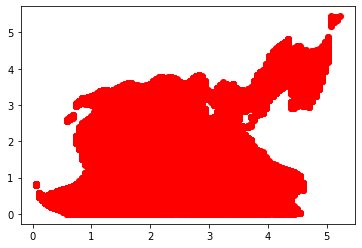

In [33]:
# arrays = [[], []]
# for i, item in objects.theta_dis.items():
#     for j in range(item.shape[0]):
#         arrays[0].append(i)
#         arrays[1].append(item[j, 0])
plt.plot(np.array(objects.plots[0]), np.array(objects.plots[1]), 'ro')
plt.show()

In [ ]:
objects.visual()

In [ ]:
def render_obj(objects):
    # mapper, vtkPolyData to graphics primitives
    mapper = vtk.vtkPolyDataMapper()
    mapper.SetInputData(objects)

    # actor, represents an object (geometry & properties) in a rendered scene
    actor = vtk.vtkActor()
    actor.SetMapper(mapper)
    
    # renderer
    ren = vtk.vtkRenderer()
    ren.SetBackground(ColorBackground)
    ren.AddActor(actor)

    # render window
    renWin = vtk.vtkRenderWindow()
    renWin.AddRenderer(ren)

    # Create a renderwindowinteractor
    iren = vtk.vtkRenderWindowInteractor()
    iren.SetRenderWindow(renWin)
    
    # visualize
    iren.Initialize()
    renWin.Render()
    iren.Start()

In [ ]:
# v1 scale ambiguous
class colon_v1(object):
    def __init__(self, path):
        reader = vtk.vtkOBJReader()
        reader.SetFileName(Path)
        reader.Update()
        self.obj = reader.GetOutput()               
        self.math = vtk.vtkMath()
        
        # renderer
        self.ren = vtk.vtkRenderer()
        self.ren.SetBackground(ColorBackground)
        self.actors = {}
        
        # add colon
        # self.add_render(self.obj, 'main')
        
    
    def add_render(self, obj, name, color=None):
        # mapper, vtkPolyData to graphics primitives
        mapper = vtk.vtkPolyDataMapper()
        mapper.SetInputData(obj)
        # actor, represents an object (geometry & properties) in a rendered scene
        actor = vtk.vtkActor()
        actor.SetMapper(mapper)
        if color:
            actor.GetProperty().SetColor(color)
        
        self.actors[name] = actor
        self.ren.AddActor(self.actors[name])
    
    def remove_render(self, name):
        self.ren.RemoveActor(self.actors[name])
        del self.actors[name]
    
    def visual(self):        
        # render window
        renWin = vtk.vtkRenderWindow()
        renWin.AddRenderer(self.ren)
        # Create a renderwindowinteractor
        iren = vtk.vtkRenderWindowInteractor()
        iren.SetRenderWindow(renWin)
        # visualize
        iren.Initialize()
        renWin.Render()
        iren.Start()
        
    def set_centerline(self, resolution):
        xmin,xmax, ymin,ymax, zmin,zmax = self.obj.GetBounds()
        center = self.obj.GetCenter() # colon center
        # key points
        pts = vtk.vtkPoints()
        pts.InsertNextPoint([center[0], center[1], zmin])
        pts.InsertNextPoint(center)
        pts.InsertNextPoint([center[0], center[1], zmax])
        
        # spline from keypoints
        spline = vtk.vtkParametricSpline() 
        spline.SetPoints(pts)
        function = vtk.vtkParametricFunctionSource()
        function.SetParametricFunction(spline)
        function.Update()
        function.SetUResolution(resolution)
        function.Update()
        self.centerline = function.GetOutput() # centerline
        self.cl_scale = (zmax-zmin)/resolution
        
        # centerline direction, [0, 0, 1]
        self.direction = [0, 0, zmax-zmin]
        self.math.Normalize(self.direction) 
        
    def cs_cut(self):
        # all tangents [0, 0, 1]
        N = self.centerline.GetNumberOfPoints()
        Tangents = vtk.vtkDoubleArray()
        Tangents.SetNumberOfComponents(3)
        Tangents.SetNumberOfTuples(N)
        for i in range(N):
            Tangents.SetTuple(i, self.direction) 
            
        # cutter, find cross section
        cutter = vtk.vtkCutter()
        cutter.SetInputData(self.obj)
        connectivityFilter = vtk.vtkPolyDataConnectivityFilter()
        connectivityFilter.SetInputConnection(cutter.GetOutputPort())
        connectivityFilter.SetExtractionModeToClosestPointRegion()
        plane = vtk.vtkPlane()
        self.all_cs = vtk.vtkAppendPolyData()
        self.cs_deform = vtk.vtkPolyData()
        self.cs_points = vtk.vtkPoints()
        self.arrays = [[], []]
        
        for i in range(N):
            # cut, get cross section
            centerPoint = [0] * 3
            self.centerline.GetPoint(i, centerPoint)
            connectivityFilter.SetClosestPoint(centerPoint)
            plane.SetOrigin(self.centerline.GetPoint(i))
            plane.SetNormal(Tangents.GetTuple(i))
            cutter.SetCutFunction(plane)
            cutter.Update()
            connectivityFilter.Update()
            cutline = cutter.GetOutput()
            
            newcut = vtk.vtkPolyData()
            newcut.DeepCopy(cutline)
            self.all_cs.AddInputData(newcut)
            self.all_cs.Update()
            self.add_render(newcut, 'cut%d' % i, (255, 0, 0))
                        
            n_p = newcut.GetNumberOfPoints()
            
            # origin direction on plane, [0, tz, -ty]
            # TODO: nake sure tangent not [1, 0, 0]
            tangent_d = Tangents.GetTuple(i)
            origin_d = [0, tangent_d[2], -tangent_d[1]]
            self.math.Normalize(origin_d)
            for j in range(n_p):
                p = newcut.GetPoint(j)
                dj = [0] * 3
                self.math.Subtract(p, centerPoint, dj)
                self.math.Normalize(dj)
                cos_theta = self.math.Dot(origin_d, dj)
                cos_theta = min(1, max(cos_theta, -1))
                theta = math.acos(cos_theta)
                if dj[0] < 0:
                    theta = - theta
                self.cs_points.InsertNextPoint(i, theta*10, 0)  
                self.arrays[0].append(i)
                self.arrays[1].append(theta*10)
                            
        self.all_cs = self.all_cs.GetOutput()
        self.cs_deform.SetPoints(self.cs_points)
        
objects_v1 = colon_v1(Path)
objects_v1.set_centerline(100)
objects_v1.add_render(objects_v1.centerline, 'centerline', (255, 255, 0))
objects_v1.cs_cut()
objects_v1.visual()
# plt.plot(np.array(objects.arrays[0]), np.array(objects.arrays[1]), 'ro')
# plt.show()
render_pc(objects_v1.cs_deform, 'v1.png')

In [ ]:
# Edges on colon
# cell edges
edges = vtk.vtkExtractEdges()
edges.SetInputData(objects.obj)
edges.Update()
objects.add_render(edges.GetOutput(), (255, 0, 0))
objects.visual()

In [ ]:
featureEdges = vtk.vtkFeatureEdges()
featureEdges.SetInputData(objects.obj)
featureEdges.BoundaryEdgesOn()
featureEdges.FeatureEdgesOff()
featureEdges.ManifoldEdgesOff()
featureEdges.NonManifoldEdgesOff()
featureEdges.ColoringOn()
featureEdges.Update()
Edges = featureEdges.GetOutput()

In [ ]:
objects.add_render(Edges, 'edges')
objects.visual()

In [ ]:
objects.remove_render('edges')
objects.visual()

In [ ]:
print(Edges)

In [ ]:
# 3d voxel -> math morphology
import math
def polygon2image(obj):
    '''cylinder = vtk.vtkCylinderSource()
    cylinder.SetHeight(3.0)
    cylinder.SetCenter(0.0, 0.0, 0.0)
    cylinder.SetRadius(1.0)
    cylinder.SetResolution(50)
    cylinder.Update()
    obj = cylinder.GetOutput()'''
    
    mapper = vtk.vtkPolyDataMapper()
    mapper.SetInputData(obj)
    # actor, represents an object (geometry & properties) in a rendered scene
    Actor = vtk.vtkActor()
    Actor.SetMapper(mapper)
    Renderer = vtk.vtkRenderer()
    Renderer.AddActor(Actor)
    renderWindow = vtk.vtkRenderWindow()
    renderWindow.AddRenderer(Renderer)
    iren = vtk.vtkRenderWindowInteractor()
    iren.SetRenderWindow(renderWindow)
    # visualize
    iren.Initialize()
    renderWindow.Render()
    iren.Start()
    
    whiteImage = vtk.vtkImageData()
    bounds = obj.GetBounds()
    print(bounds)
    # obj.GetBounds(bounds)
    spacing = [0.1, 0.1, 0.1]
    whiteImage.SetSpacing(spacing)
    dim = [
        int(math.ceil((bounds[1] - bounds[0])/spacing[0])) + 1,
        int(math.ceil((bounds[3] - bounds[2])/spacing[1])) + 1,
        int(math.ceil((bounds[5] - bounds[4])/spacing[2])) + 1
    ]
    whiteImage.SetDimensions(dim);
    whiteImage.SetExtent(0, dim[0] - 1, 0, dim[1] - 1, 0, dim[2] - 1)

    origin = [
        bounds[0] + spacing[0] / 2,
        bounds[2] + spacing[1] / 2,
        bounds[4] + spacing[2] / 2
    ]
    whiteImage.SetOrigin(origin)
    whiteImage.AllocateScalars(vtk.VTK_UNSIGNED_CHAR,1)
    
    count = whiteImage.GetNumberOfPoints()
    for i in range(count):
        whiteImage.GetPointData().GetScalars().SetTuple1(i, 255)
    
    pol2stenc = vtk.vtkPolyDataToImageStencil()
    pol2stenc.SetInputData(obj)
    pol2stenc.SetOutputOrigin(origin)
    pol2stenc.SetOutputSpacing(spacing)
    pol2stenc.SetOutputWholeExtent(whiteImage.GetExtent())
    pol2stenc.Update()
    
    image = vtk.vtkImageStencil()
    image.SetInputData(whiteImage)
    image.SetStencilConnection(pol2stenc.GetOutputPort())
    image.ReverseStencilOff()
    image.SetBackgroundValue(0)
    image.Update()
    print(image.GetOutput())
    
    mapper = vtk.vtkDataSetMapper()
    mapper.SetInputConnection(image.GetOutputPort())
    Actor = vtk.vtkActor()
    Actor.SetMapper(mapper)
    Renderer = vtk.vtkRenderer()
    Renderer.SetBackground([255, 0, 0])
    Renderer.AddActor(Actor)
    renderWindow = vtk.vtkRenderWindow()
    renderWindow.AddRenderer(Renderer)
    iren = vtk.vtkRenderWindowInteractor()
    iren.SetRenderWindow(renderWindow)
    # visualize
    iren.Initialize()
    renderWindow.Render()
    iren.Start()


In [ ]:
polygon2image(objects.obj)